#  <font color='blue'>Mean Machine - Polynomial, Ridge and LASSO</font>

In this notebook we will use a sinusoidal function with some noise. The tasks herewith are to
* fit the data with polynomial function and discover the overfitting as the degree increases
* fit the data with ridge regression (L2 penalty) to kill overfitting
* fit the data with LASSO regression (L1 penalty) to kill overfitting and select feature

# 1: Set the path that includes all relevant files

In [1]:
import os                                               # 操作系统用来管理文件路径
os.chdir("C:\Users\stevenwsy\Desktop\Steven - Python")  # 将路径改为 "C:\Users\stevenwsy\Desktop\Steven - Python"

# 注意：你们要把 "C:\Users\stevenwsy\Desktop\Steven - Python" 改成在你们电脑里面的路径

# 2: Import all relevant packages

In [2]:
import random          # 用来固定随机数的种子
import numpy as np     # 用来做数学运算
import pandas as pd    # 用来处理数据表

# 将所有图都在 Notebook 里显示
%matplotlib inline               
import matplotlib.pyplot as plt  # 用来画图

from sklearn.linear_model import LinearRegression  # 线性回归
from sklearn.linear_model import Ridge             # 岭回归
from sklearn.linear_model import RidgeCV           # 岭回归交叉验证
from sklearn.linear_model import Lasso             # 套索回归
from sklearn.linear_model import LassoCV           # 套索回归交叉验证

# 3: Create and view the data

In [3]:
# Create random values for x in interval [0,1] and function y=sin(4x):
random.seed(1)
n = 30
x = np.random.rand( n, 1 )
y = np.sin(4*x)
# Add random Gaussian noise to y
random.seed(2)
e = np.random.normal( 0, 1.0/3.0, n )
y = y + e[:,np.newaxis]

### Put data into a data frame

In [4]:
data = pd.DataFrame( np.hstack((y,x)), columns=['Y','X1'] )
data.head()

,Y,X1
0,0.117900,0.097984
1,0.612294,0.325846
2,0.952220,0.428168
3,-0.773717,0.975936
4,0.463508,0.498927


In [5]:
data.describe()

,Y,X1
count,30.000000,30.000000
mean,0.556394,0.407759
std,0.575213,0.284635
min,-0.773717,0.002275
25%,0.215316,0.227854
50%,0.572050,0.338982
75%,0.936319,0.590852
max,1.734757,0.975936


### Create a function to plot the data, since we'll do it many times

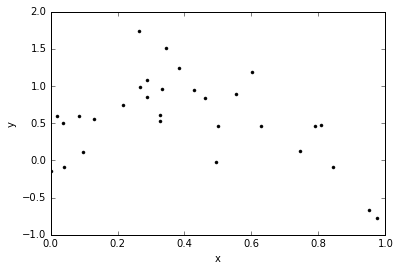

In [6]:
def plot_data(data):    
    plt.plot( data['X1'], data['Y'], 'k.', label = 'data' )
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

# 4: Polynomial Regression

Define a function to create our features for a polynomial regression model of any degree:

In [7]:
def polynomial_features( data, deg ):
    data_copy = data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)] = data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [8]:
def polynomial_regression( data, deg ):
    full_data = polynomial_features( data, deg )
    input_value = full_data.ix[:,'X1':].values
    output_value = full_data['Y'].values
    
    model = LinearRegression()
    model.fit( input_value, output_value )
    
    return model

Define function to plot data and predictions made, since we are going to use it many times.

In [9]:
def plot_poly_predictions( data, model ):
    plot_data(data)

    deg = len(model.coef_)
    
    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = pd.DataFrame( np.arange(0,200,1)/200.0, columns=['X1'] )
    x_pred = polynomial_features( x_pred, deg )
    y_pred = model.predict( x_pred.values )
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients in a pretty way :)

In [11]:
def print_coefficients( model ):        
    deg = len(model.coef_)
    # Get learned parameters as a list
    w = list( np.hstack((model.intercept_,model.coef_)) )

    # Numpy has a nifty function to print out polynomials in a pretty way
    print 'Learned polynomial for degree ' + str(deg) + ':'
    w.reverse()
    print np.poly1d(w)

## <font color='red'>Fit a degree-2 polynomial<font>

Fit our degree-2 polynomial to the data generated above:

Learned polynomial for degree 2:
        2
-5.039 x + 4.021 x + 0.1493


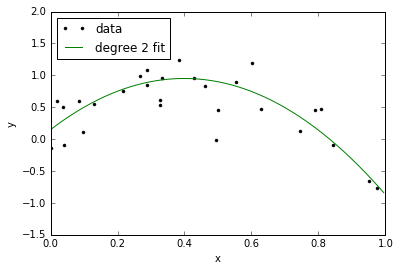

In [12]:
model = polynomial_regression( data, deg=2 )
print_coefficients( model )
plot_poly_predictions( data, model )

## <font color='red'>Fit a degree-4 polynomial<font>

Learned polynomial for degree 4:
        4         3         2
-17.57 x + 35.85 x - 28.36 x + 9.098 x - 0.05173


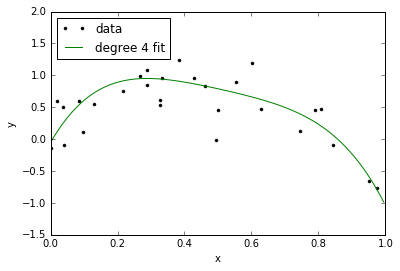

In [13]:
model = polynomial_regression( data, deg=4 )
print_coefficients( model )
plot_poly_predictions( data, model )

## <font color='red'>Fit a degree-16 polynomial<font>

Learned polynomial for degree 16:
          16            15             14             13             12
3.13e+08 x  - 1.79e+09 x  + 4.082e+09 x  - 4.007e+09 x  - 7.299e+08 x 
              11             10             9             8
 + 6.955e+09 x  - 9.426e+09 x  + 7.289e+09 x - 3.724e+09 x
              7             6             5             4             3
 + 1.309e+09 x - 3.184e+08 x + 5.272e+07 x - 5.734e+06 x + 3.846e+05 x
              2
 - 1.425e+04 x + 233.6 x - 0.6234


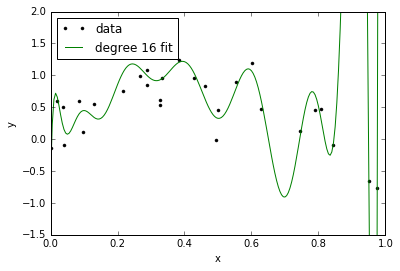

In [14]:
model = polynomial_regression( data, deg=16 )
print_coefficients( model )
plot_poly_predictions( data, model )

### <font color= green> Woah!!!!  Those coefficients are *crazy*!  On the order of 10^7 <font>
## <font color= red> Fitting looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.<font>

# 5: Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on $\|w\|^{2}$.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter $\lambda$ (here called "L2_penalty").

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [15]:
def ridge_regression( data, deg, l2_penalty ):
    full_data = polynomial_features( data, deg )
    input_value = full_data.ix[:,'X1':].values
    output_value = full_data['Y'].values
    
    model = Ridge(l2_penalty)
    model.fit( input_value, output_value )
    return model

## <font color='red'>Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength<font>

Learned polynomial for degree 16:
           16             15             14             13
3.136e+08 x  - 1.794e+09 x  + 4.096e+09 x  - 4.035e+09 x 
              12            11             10             9
 - 6.928e+08 x  + 6.92e+09 x  - 9.402e+09 x  + 7.277e+09 x
              8             7             6             5             4
 - 3.719e+09 x + 1.308e+09 x - 3.181e+08 x + 5.269e+07 x - 5.731e+06 x
              3             2
 + 3.845e+05 x - 1.424e+04 x + 233.6 x - 0.6232


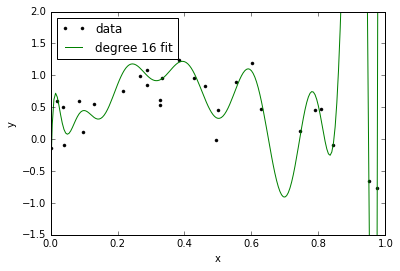

In [16]:
model = ridge_regression( data, deg=16, l2_penalty=1e-25 )
print_coefficients( model )
plot_poly_predictions( data, model )

## <font color='red'>Perform a ridge fit of a degree-16 polynomial using a very large penalty strength<font>

Learned polynomial for degree 16:
          16           15           14           13           12
-0.01284 x  - 0.01336 x  - 0.01392 x  - 0.01452 x  - 0.01517 x 
            11           10           9           8          7
 - 0.01586 x  - 0.01662 x  - 0.01744 x - 0.01833 x - 0.0193 x
            6           5           4           3           2
 - 0.02033 x - 0.02137 x - 0.02226 x - 0.02252 x - 0.02069 x - 0.01259 x + 0.5872


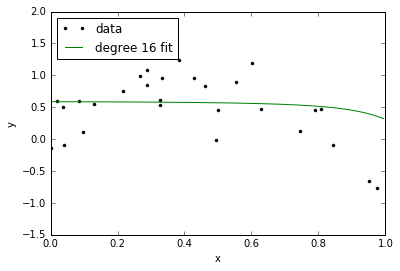

In [17]:
model = ridge_regression( data, deg=16, l2_penalty=100 )
print_coefficients( model )
plot_poly_predictions( data, model )

## <font color='red'>Let's look at fits for a sequence of increasing $\lambda$ values<font>

lambda = 1.00e-25
Learned polynomial for degree 16:
           16             15             14             13
3.136e+08 x  - 1.794e+09 x  + 4.096e+09 x  - 4.035e+09 x 
              12            11             10             9
 - 6.928e+08 x  + 6.92e+09 x  - 9.402e+09 x  + 7.277e+09 x
              8             7             6             5             4
 - 3.719e+09 x + 1.308e+09 x - 3.181e+08 x + 5.269e+07 x - 5.731e+06 x
              3             2
 + 3.845e+05 x - 1.424e+04 x + 233.6 x - 0.6232


lambda = 1.00e-10
Learned polynomial for degree 16:
       16        15         14        13        12         11        10
-2041 x  + 4225 x  + 978.6 x  - 3173 x  - 3541 x  + 3.809 x  + 3928 x 
         9        8        7        6        5        4        3
 + 3863 x - 1220 x - 5887 x - 1331 x + 8830 x - 6217 x + 1793 x
          2
 - 226.1 x + 13.8 x + 0.02099


lambda = 1.00e-06
Learned polynomial for degree 16:
        16         15         14         13        12      11        

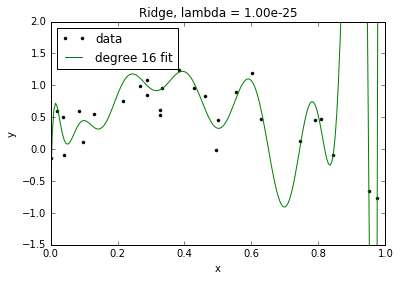

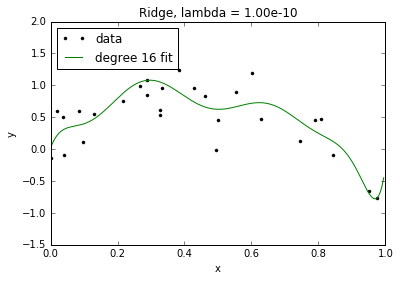

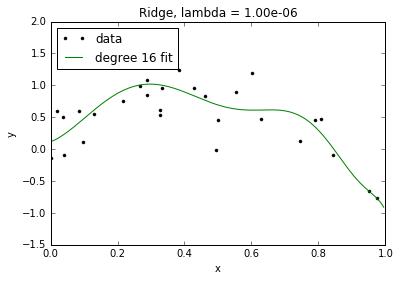

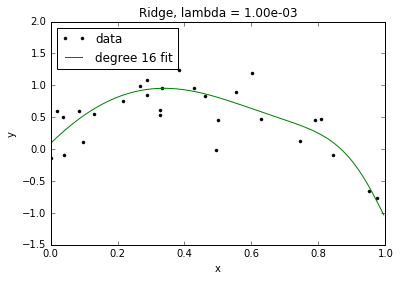

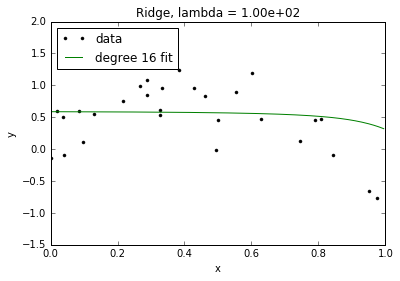

In [18]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = ridge_regression( data, deg=16, l2_penalty=l2_penalty )
    print 'lambda = %.2e' % l2_penalty
    print_coefficients( model )
    print '\n'
    plt.figure()
    plot_poly_predictions( data, model )
    plt.title( 'Ridge, lambda = %.2e' % l2_penalty )

## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) $\lambda$.  Here, we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE).  As a result, choosing $\lambda$ to minimize the LOO error is equivalent to choosing $\lambda$ to minimize an approximation to average MSE.

In [19]:
def loo_ridge( data, deg, l2_penalty_values ):
    
    full_data = polynomial_features( data, deg )
    input_value = full_data.ix[:,'X1':].values
    output_value = full_data['Y'].values
    
    best_model = RidgeCV( l2_penalty_values )
    best_model.fit( input_value, output_value )
    
    best_l2_penalty = best_model.alpha_
    
    return best_l2_penalty

Run LOO cross validation for "num" values of $\lambda$, on a log scale

In [20]:
l2_penalty_values = np.logspace( -4, 10, num=20 )
best_l2_penalty = loo_ridge( data, 16, l2_penalty_values )
print best_l2_penalty

0.000545559478117


Learned polynomial for degree 16:
       16         15          14          13         12         11
2.658 x  + 1.507 x  + 0.3789 x  - 0.6725 x  - 1.573 x  - 2.221 x 
          10         9         8          7         6         5
 - 2.483 x  - 2.202 x - 1.234 x + 0.4532 x + 2.562 x + 4.101 x
          4         3         2
 + 3.078 x - 2.483 x - 8.503 x + 5.629 x + 0.06303


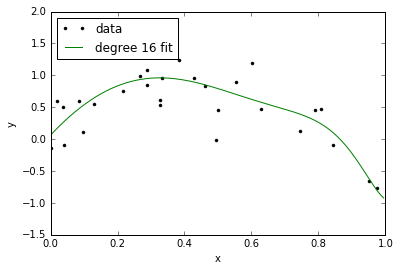

In [21]:
best_model = ridge_regression( data, deg=16, l2_penalty=best_l2_penalty )
print_coefficients ( best_model )
plot_poly_predictions( data, best_model )

# 6: Lasso Regression

Lasso regression jointly shrinks coefficients to avoid overfitting, and implicitly performs feature selection by setting some coefficients exactly to 0 for sufficiently large penalty strength $\lambda$ (here called "L1_penalty").  In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

Define our function to solve the lasso objective for a polynomial regression model of any degree:

In [22]:
def lasso_regression( data, deg, l1_penalty ):
    full_data = polynomial_features( data, deg )
    input_value = full_data.ix[:,'X1':].values
    output_value = full_data['Y'].values
    
    model = Lasso(l1_penalty)
    model.fit( input_value, output_value )
    return model

## <font color = red>Explore the lasso solution as a function of a few different penalty strengths<font>

l1_penalty = 1.000000e-04
number of nonzeros = 10
Learned polynomial for degree 16:
         12          11        10          9     8     7         5
-0.2123 x  - 0.6699 x  - 1.11 x  - 0.4173 x - 0 x - 0 x + 1.388 x
         4          3        2
 + 3.21 x + 0.1559 x - 9.19 x + 5.555 x + 0.07276


l1_penalty = 1.000000e-03
number of nonzeros = 5
Learned polynomial for degree 16:
          15          14     13     12     11     10     9     8     7
-0.03947 x  - 0.2993 x  - 0 x  - 0 x  - 0 x  - 0 x  - 0 x - 0 x - 0 x
      6     5     4     3         2
 - 0 x - 0 x - 0 x - 0 x - 4.363 x + 3.484 x + 0.2185


l1_penalty = 1.000000e-02
number of nonzeros = 4
Learned polynomial for degree 16:
         5         4     3     2
-0.7974 x - 1.064 x - 0 x - 0 x + 0.4537 x + 0.6031


l1_penalty = 1.000000e-01
number of nonzeros = 1
Learned polynomial for degree 16:
 
0.5564


l1_penalty = 1.000000e+00
number of nonzeros = 1
Learned polynomial for degree 16:
 
0.5564




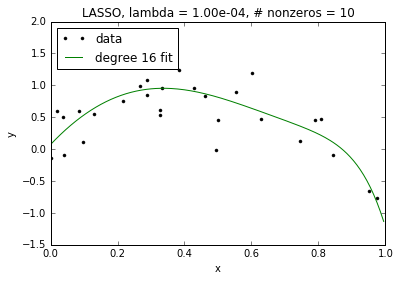

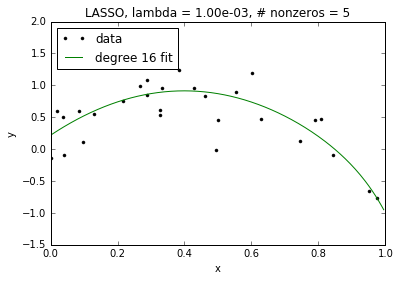

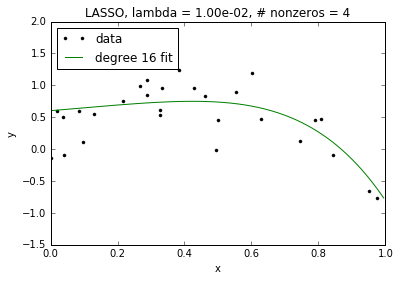

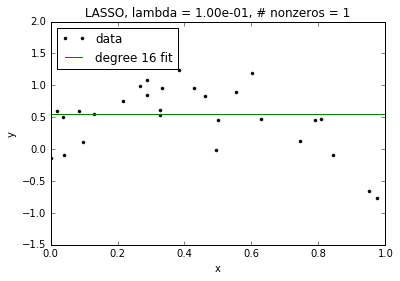

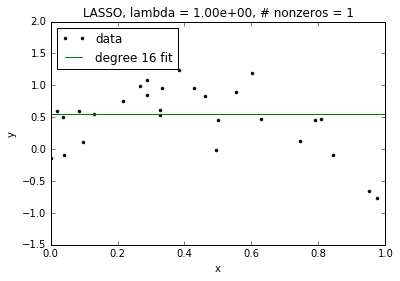

In [24]:
for l1_penalty in [0.0001, 0.001, 0.01, 0.1, 1]:
    model = lasso_regression( data, deg=16, l1_penalty=l1_penalty )
    print 'l1_penalty = %e' % l1_penalty
    coefficients = np.hstack((model.intercept_,model.coef_))
    n = sum(coefficients != 0)
    print 'number of nonzeros = %d' % n
    print_coefficients( model )
    print '\n'
    plt.figure()
    plot_poly_predictions( data, model )
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (l1_penalty, n))

Above: We see that as lambda increases, we get sparser and sparser solutions.  However, even for our non-sparse case for lambda=0.0001, the fit of our high-order polynomial is not too wild.  This is because, like in ridge, coefficients included in the lasso solution are shrunk relative to those of the least squares (unregularized) solution.  This leads to better behavior even without sparsity.  Of course, as lambda goes to 0, the amount of this shrinkage decreases and the lasso solution approaches the (wild) least squares solution.

In [25]:
def loo_Lasso( data, deg, l1_penalty_values ):
    
    full_data = polynomial_features( data, deg )
    input_value = full_data.ix[:,'X1':].values
    output_value = full_data['Y'].values
    
    best_model = LassoCV( alphas=l1_penalty_values )
    best_model.fit( input_value, output_value )
    
    best_l1_penalty = best_model.alpha_
    
    return best_l1_penalty

In [26]:
l1_penalty_values = np.logspace( -4, 10, num=20 )
best_l1_penalty = loo_Lasso( data, 16, l1_penalty_values )
print best_l1_penalty

0.0001


Learned polynomial for degree 16:
         12          11        10          9     8     7         5
-0.2123 x  - 0.6699 x  - 1.11 x  - 0.4173 x - 0 x - 0 x + 1.388 x
         4          3        2
 + 3.21 x + 0.1559 x - 9.19 x + 5.555 x + 0.07276


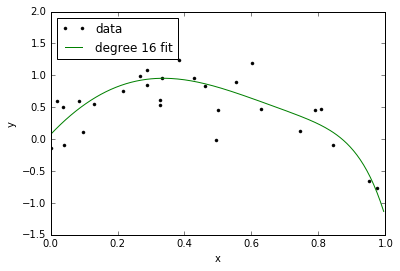

In [27]:
best_model = lasso_regression( data, deg=16, l1_penalty=best_l1_penalty )
print_coefficients ( best_model )
plot_poly_predictions( data, best_model )